In [1]:
import os
import sys
import torch
import numpy as np

# Set default tensor data type to float64
torch.set_default_dtype(torch.float64)

# Import the required model
from model import TimeEmbeddingBlockDiagonalKoopman

# Ensure the utils directory is in the module search path
if '__file__' in globals():
    # Script execution: Use __file__ to get the directory
    current_dir = os.path.dirname(__file__)
else:
    # Interactive environment: Use the current working directory
    current_dir = os.getcwd()

sys.path.append(os.path.join(current_dir, '../utils'))

# Import utility functions
from args_arguments import parse_arguments, read_config_file
from load_dataset import load_dataset_from_files
from data_preparation import (
    data_delete_columns, 
    data_preprocessing, 
    build_time_embedding_train_test_dataloader
)

# Example message to confirm successful setup
print("Setup complete. Modules and utilities imported successfully.")

Setup complete. Modules and utilities imported successfully.


In [2]:
config_path = '/home/shiqi/code/Project4-power-grid/non-autonomous-koopman/outputs/experiment1/config.yaml'
config = read_config_file(config_path)
device = torch.device('cpu')
x_dataset, u_dataset = load_dataset_from_files(config)

x_dataset = data_delete_columns(x_dataset)
rescale_pca_layer, x_dataset_new, u_dataset_new = data_preprocessing(x_dataset, u_dataset, config['pca_dim'])

In [3]:
model = TimeEmbeddingBlockDiagonalKoopman(dictionary_dim = config['dictionary_dim'], inputs_dim = config['N'] * config['pca_dim'], num_blocks = config['num_blocks'])
model.to(device)
model_path = os.path.join(config['save_dir'], 'model.pth')
model.load_state_dict(torch.load(model_path))
model.eval()

losses_path = os.path.join(config['save_dir'], 'losses.pth')
losses = torch.load(losses_path)
train_losses = losses['train_losses']
test_losses = losses['test_losses']

print(f"Model loaded from {model_path}")
print(f"Losses loaded from {losses_path}")

Model loaded from outputs/experiment1/model.pth
Losses loaded from outputs/experiment1/losses.pth


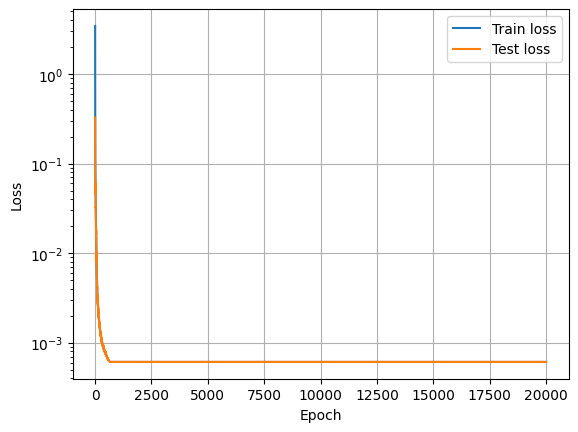

In [4]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig(os.path.join(config['save_dir'], 'losses.pdf'))
plt.show()


In [5]:
print(rescale_pca_layer)

Rescale_pca_layer(
  (std_layer_1): StdScalerLayer()
  (std_layer_2): StdScalerLayer()
  (std_layer_u): StdScalerLayer()
  (pca_layer): PCALayer(
    (transform): Linear(in_features=65, out_features=2, bias=False)
    (inverse_transform): Linear(in_features=2, out_features=65, bias=False)
  )
)


In [6]:
# Evaluate model
x_dataset_eval = []
for x_data in x_dataset:
    x_data_eval = torch.tensor(x_data, dtype=torch.float64).to(device)
    # print(x_data_eval.shape)
    x_data_eval = rescale_pca_layer.transform_x(x_data_eval)
    x_dataset_eval.append(x_data_eval)

In [7]:
print(model.koopman.forward_K().shape)
print(model.koopman.forward_V().shape)

torch.Size([61, 61])
torch.Size([61, 61])


In [8]:

x_dataset_pred = []
err_dataset = []
end_point = config['N'] * config['pca_dim']
begin_point = config['N'] * config['pca_dim'] - config['pca_dim']
print(begin_point, end_point)
for x_data_eval in x_dataset_eval:
    L = x_data_eval.shape[0]
    x0 = x_data_eval[:config['N'], :]
    x_data_pred = torch.zeros_like(x_data_eval)
    x_data_pred[0:config['N'], :] = x0
    x0_dic = model.dictionary_V(x0.reshape(1, -1))
    
    V_inv = torch.inverse(model.koopman.V)
    K = model.koopman.forward_K()
    for i in range(config['N'], L):
        x_pred_dic = torch.matmul(x0_dic, K)
        x_pred = torch.matmul(x_pred_dic, V_inv)[:, 1+begin_point:end_point+1]
        x0_dic = x_pred_dic
        x_data_pred[i, :] = x_pred
    err = x_data_eval - x_data_pred
    err_dataset.append(err.cpu().detach().numpy())
    x_dataset_pred.append(x_data_pred.cpu().detach().numpy())

# Save results
results = {'x_dataset_eval': x_dataset_eval, 'x_dataset_pred': x_dataset_pred, 'err_dataset': err_dataset}
results_path = os.path.join(config['save_dir'], 'results.pth')
torch.save(results, results_path)
print(f"Results saved to {results_path}")

18 20
Results saved to outputs/experiment1/results.pth


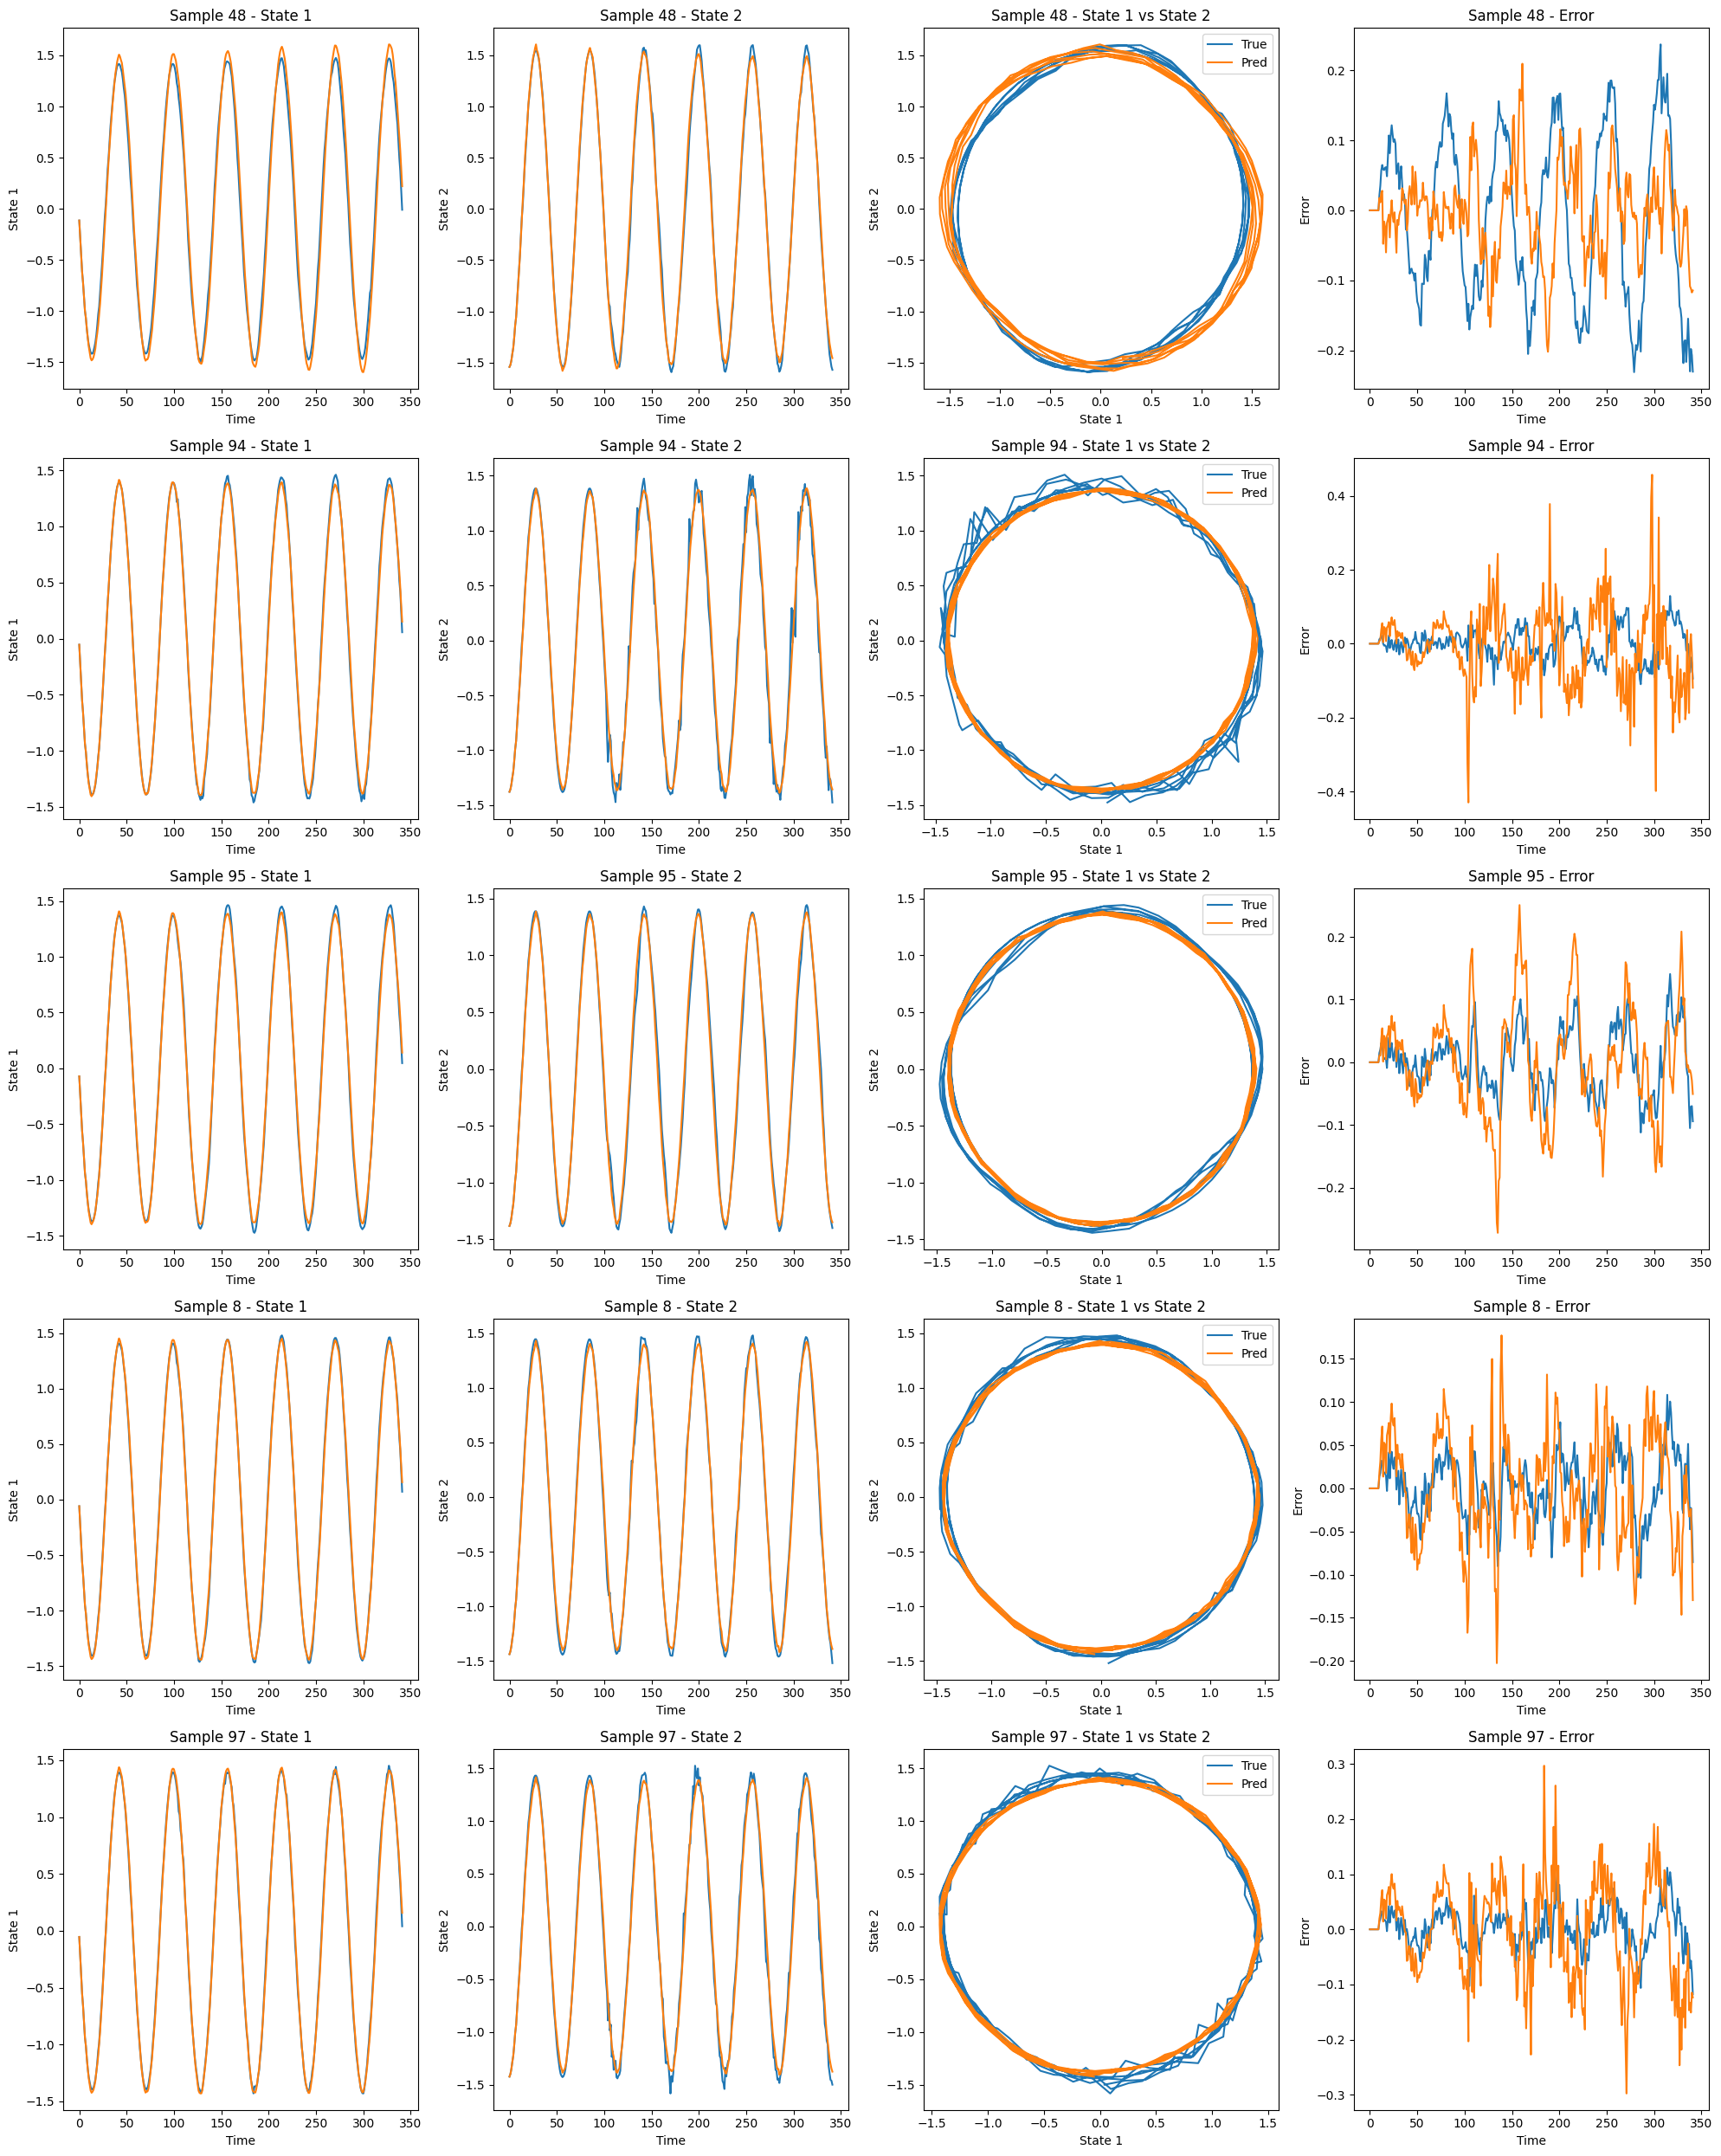

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Select random indices for plotting
random_indices = np.random.choice(len(x_dataset_eval), 5, replace=False)

# Create subplots
fig, axs = plt.subplots(5, 4, figsize=(20, 25))

for i, idx in enumerate(random_indices):
    x_data_eval = x_dataset_eval[idx]
    x_data_pred = x_dataset_pred[idx]
    
    # Plot State 1
    axs[i, 0].plot(x_data_eval[:, 0], label='True')
    axs[i, 0].plot(x_data_pred[:, 0], label='Pred')
    axs[i, 0].set_title(f'Sample {idx} - State 1')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('State 1')
    # axs[i, 0].legend()
    
    # Plot State 2
    axs[i, 1].plot(x_data_eval[:, 1], label='True')
    axs[i, 1].plot(x_data_pred[:, 1], label='Pred')
    axs[i, 1].set_title(f'Sample {idx} - State 2')
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('State 2')
    # axs[i, 1].legend()

    # Plot State 1 vs State 2
    axs[i, 2].plot(x_data_eval[:, 0], x_data_eval[:, 1], label='True')
    axs[i, 2].plot(x_data_pred[:, 0], x_data_pred[:, 1], label='Pred')
    axs[i, 2].set_title(f'Sample {idx} - State 1 vs State 2')
    axs[i, 2].set_xlabel('State 1')
    axs[i, 2].set_ylabel('State 2')
    axs[i, 2].legend()

    # Plot Error
    err = err_dataset[idx]
    axs[i, 3].plot(err)
    axs[i, 3].set_title(f'Sample {idx} - Error')
    axs[i, 3].set_xlabel('Time')
    axs[i, 3].set_ylabel('Error')
    

# Adjust layout for better readability
plt.tight_layout()
plt.show()